In [1]:
# Functions and imports
import sys
import os
from os.path import join as pjoin
from glob import glob
import numpy as np
from scipy.stats import mode
import time
from shutil import rmtree
import dask.multiprocessing
from dask import array as da
from dask import delayed
from dask.distributed import Client, progress
from cv2 import setNumThreads,warpAffine
from imaging import strNumberSort, estimate2PLineShift
from imaging.sbx import sbx_get_shape as sbxGetShape
from imaging.sbx import sbx_memmap,sbx_get_info
from scipy.ndimage.filters import correlate, convolve
import h5py as h5
from dask.array import stats as dastats
from tifffile import imsave,imread
#from skimage.feature import register_translation
from imaging import  dftreg_TranslationShift as register_translation
setNumThreads(1)

def _search_for_ext(exppath,extension = 'sbx',
                    minFilesPerRun = 1):
    if os.path.isdir(exppath):
        tmp = strNumberSort(os.listdir(exppath))
        # List only folders with over some minFilesPerRun files
        runs = []
        for f in tmp:
            if os.path.isdir(pjoin(exppath,f)):
                if (len(glob(pjoin(exppath,f,
                                   '*.'+extension))) >= minFilesPerRun):
                    runs.append(f)
                else:
                    print('Discarding run (insuficient files):' + f)
        files = []
        for run in runs:
            files.append(np.array(strNumberSort(
                glob(pjoin(exppath,run,'*.'+extension)))))
        return runs,files
    else:
        return None,None


def loadSBXblock(block,
                 shape = None,trimleft = 95,trimright=0,shiftLines = 0): 
    '''Loads a block of a scanbox file (nchannels,W,H,nplanes)
    Returning shape is a Frames x Planes x Channels X H x W array.
    Subtracts data to 2**16 and removes a chunck of artifact.'''
    fname,offset,bsize = block
    nchans,W,H,nplanes = shape
    framesize = nchans*W*H
    with open(fname,'r') as fd:
        fd.seek(offset*framesize*np.uint16().itemsize)
        buf = np.fromfile(fd,dtype = 'uint16',count=framesize*bsize)
    buf = buf.reshape((nchans,W,H,bsize),
                               order='F').transpose([3,0,2,1]).reshape(
                                   int(bsize/nplanes),
                                   nplanes,
                                   nchans,
                                   H,W)
    
    buf[:,:,:,::2,:] = np.roll(buf[:,:,:,::2,:],shiftLines,axis = -1)
    buf = buf[:,:,:,:,int(trimleft):]
    if not trimright == 0:
        buf = buf[:,:,:,:,:int(-1*trimright)]
    return 65535 - buf

def prepareSBXdaskLoad(sbxfile,blocksize = 128,trimleft = 95,trimright = 0, shiftLines = 0):
    (nchans,W,H,filesize),nplanes = sbxGetShape(sbxfile)
    # Even frames on all planes by trimming to last bit.
    nframes = int(filesize/nplanes*nplanes)
    print('\t\t Number of frames [{1}]: {0}'.format(nframes,sbxfile))
    iblocks = np.arange(0,nframes,nplanes*blocksize)
    if iblocks[-1] < nframes:
        iblocks = np.append(iblocks,nframes)
    framesize = nchans*W*H
    blocks = []
    for ii,offset in enumerate(iblocks[:-1]):
        bsize = iblocks[ii+1] - offset
        blocks.append((sbxfile,offset,bsize))
    lazyload = delayed(lambda x: loadSBXblock(x,
                                              shape=(nchans,W,H,nplanes),
                                              trimleft = trimleft,
                                              trimright = trimright,
                                              shiftLines = shiftLines), 
                       pure=True)  # Lazy version of loadSBX
    sample = loadSBXblock(blocks[0],shape=(nchans,W,H,nplanes))
    lazy_values = [lazyload(block) for block in blocks] 
    arrays = [da.from_delayed(lazy_value,           
                              dtype=sample.dtype,   
                              shape=[block[-1]/nplanes] + [s for s in sample.shape[1:]])
          for block,lazy_value in zip(blocks,lazy_values)]
    info= sbx_get_info(sbxfile)
    return (da.concatenate(arrays, axis=0), ((nchans,W,H,filesize),nplanes),info)

def regFrames(frames,ref,offset = [0,0], discardBorder = 100,iChannelReg = 0):
    nFrames,nPlanes,nChannels,height,width = frames.shape
    #shifts = np.zeros([nFrames,nPlanes,2],dtype=np.float32)
    res = np.zeros_like(frames)

    setNumThreads(1)
    for iPlane in range(nPlanes):
        reference = ref[iPlane][iChannelReg][discardBorder:-1-discardBorder,
                                             discardBorder:-1-discardBorder]
        for iFrame in range(nFrames):
            frame = frames[iFrame,iPlane,iChannelReg,
                           discardBorder:-1-discardBorder,
                           discardBorder:-1-discardBorder]
            shift,_,_ = register_translation(reference,frame,upsample_factor=6)
            #shifts[iFrame,iPlane,:] = shift[:].astype('float32')
            M = np.float32([[1,0,shift[1] + offset[1]],
                            [0,1,shift[0]+ offset[0]]])
            for iChannel in range(nChannels):
                res[iFrame,iPlane,iChannel,:,:] = warpAffine(frames[iFrame,
                                                                    iPlane,
                                                                    iChannel,
                                                                    :,:],
                                                             M,(width,height))

    return res


def computeReferenceImages(stacks,nReferenceFrames = 1200,client=None, reg = True):
    nn = int(nReferenceFrames/2) # number of frames
    delayed_ref = []
    delayed_1ref = []
    delayed_2ref = []
    for i,stack in enumerate(stacks):
        substack = stack[stack.shape[0]/2-nn:stack.shape[0]/2+nn]
        delayed_ref.append(substack.mean(axis=0))
        if reg:
            delayed_1ref.append(substack.map_blocks(regFrames,delayed_ref[-1],
                                                    dtype=np.uint16).mean(axis=0))
            delayed_2ref.append(substack.map_blocks(regFrames,delayed_1ref[-1],
                                                    dtype=np.uint16).mean(axis=0))
    if not reg:
        return client.compute(delayed_ref)
    else:
        return client.compute(delayed_2ref)

def stackToTiff(frames,filename, block_id = None, multiplane_tiffs = False):
    nFrames,nPlanes,nChannels,height,width = frames.shape
    if not multiplane_tiffs:
        for iChannel in range(nChannels):
            for iPlane in range(nPlanes):
                fname = filename.format(iPlane+1,iChannel,block_id[0])
                if not os.path.exists(os.path.dirname(fname)):
                    try:
                        os.makedirs(os.path.dirname(fname))
                    except:
                        pass
                imsave(fname,np.squeeze(frames[:,iPlane,iChannel,:,:]),
                       photometric = 'minisblack', imagej = False)
    else:
        if height > 1 and width > 1 :
            fname = filename.format(nPlanes,block_id[0])
            if not os.path.exists(os.path.dirname(fname)):
                try:
                    os.makedirs(os.path.dirname(fname))
                except:
                    pass
            imsave(fname,frames.reshape((nFrames*nPlanes*nChannels,height,width)),
                   photometric = 'minisblack', imagej = False)
    return block_id[0]*np.arange(nFrames)

def loadTiffsToDask(files):
    delayed_imread = delayed(imread, pure=True)  # Lazy version of imread
    # To load when the last file has a different dimension
    sample0 = imread(files[0])
    sample1 = imread(files[-1])

    lazy_values = []
    for f in files[:-1]:
        lazy_values.append([delayed_imread(f),sample0.shape])
    lazy_values.append([delayed_imread(files[-1]),sample1.shape])
    
    arrays = [da.from_delayed(v0,        
                              dtype=sample0.dtype, 
                              shape=v1)
              for v0,v1 in lazy_values]
    return da.concatenate(arrays, axis=0)

def local_corr(block):
    """Computes the correlation image for the input dataset Y  using a faster FFT based method
    Parameters:
    -----------
    Y:  np.ndarray (3D or 4D)
        Input movie data in 3D or 4D format
    eight_neighbours: Boolean
        Use 8 neighbors if true, and 4 if false for 3D data (default = True)
        Use 6 neighbors for 4D data, irrespectively
    swap_dim: Boolean
        True indicates that time is listed in the last axis of Y (matlab format)
        and moves it in the front
    Returns:
    --------
    Cn: d1 x d2 [x d3] matrix, cross-correlation with adjacent pixels
    
    
    This is from CaIman: https://github.com/simonsfoundation/CaImAn/blob/master/caiman/summary_images.py
    """

    Y = np.array(block).astype('float32')
    Y -= np.nanmean(Y,axis = 0)
    Y /= np.nanstd(Y,axis = 0)

    sz = np.ones((3,3),dtype='float32')
    sz[1,1] = 0

    Yconv = convolve(Y,sz[np.newaxis,:],mode='constant')
    MASK = convolve(np.ones(Y.shape[1:],dtype='float32'),sz,mode='constant')
    Cn =  (np.nanmean(Yconv*Y,axis=0)/MASK).reshape([1]+[a for a in Y.shape[1:]]).astype(np.float32)
    return Cn

def daskComputeProjections(stacks,client,chunksize = 1000,ndownsample=5, trimregds = False):
    projections = []
    downsampled = []
    
    for session in stacks:
        projections.append([])
        downsampled.append([])
        for stack in session:
            N,H,W = stack.shape
            chunks = np.arange(0,N,chunksize,dtype=int)
            if not chunks[-1] == N:
                chunks = np.append(chunks,N)
            nstack = stack.rechunk(([a for a in np.diff(chunks)], H,W))
            lcor = nstack.map_blocks(local_corr,dtype=np.float32,
                                    chunks = [1,H,W])
            if not trimregds:
                trimnframes = ((stack.shape[0]/ndownsample)*ndownsample)
            else:
                trimnframes = 1000*ndownsample
            dsstack = stack[:trimnframes,...].reshape([trimnframes/ndownsample,ndownsample] + [a for a in stack.shape[1:]])
            downsampled[-1].append(np.squeeze(dsstack.mean(axis=1).astype(np.uint16)).persist())
            dsstack = downsampled[-1][-1]
            projections[-1].append([a for a in client.persist([da.nanmean(lcor,axis=0),
                                                               dsstack.std(axis=0),
                                                               dsstack.mean(axis=0),
                                                               dastats.skew(dsstack,axis=0),
                                                               dastats.kurtosis(dsstack,axis=0)])])
            
    return projections,downsampled

def dsregToTiff(frames,filename, block_id = None):
    nFrames,height,width = frames.shape
    b1,b2,b3 = block_id
    fname = filename.format(b1)
    try:
        os.makedirs(os.path.dirname(fname))
    except:
        pass
    imsave(fname,np.squeeze(frames),
           photometric = 'minisblack',
           imagej = False)
    return b1*np.arange(nFrames)


/opt/anaconda2/envs/2p/lib/python2.7/site-packages/distributed/utils.py:118: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
from argparse import ArgumentParser
parser = ArgumentParser(description='Registration script for 2P scanbox data - DASK')
parser.add_argument('folder',metavar='foldername',
                    type=str,help='folder with raw sbx data')
parser.add_argument('-o','--output-folder',metavar='destination',
                    default=None,
                    type=str,help='folder to place reg data')
parser.add_argument('-c','--client',metavar='dask client',
                    default='/home/mouselab/dask-temp/sched.json',
                    type=str,help='dask client address or file')
parser.add_argument('--runs',metavar='run indexes ',
                    action='store',
                    type=int,
                    nargs='+',
                    default=[],
                    help='runs to register (to perform reg on - otherwise uses all) - zero based')
parser.add_argument('--no-projections',
                    action='store_true',
                    default=False,
                    help='compute projections')
parser.add_argument('--no-registration',
                    action='store_true',
                    default=False,
                    help='compute projections')
parser.add_argument('--independent-runs',
                    action='store_true',
                    default=False,
                    help='use the  reference to all runs.')
parser.add_argument('--limit-regds',
                    action='store_true',
                    default=False,
                    help='limits regds output to 1000 frames.')    
parser.add_argument('--ndownsample',
                    action='store',
                    default=6,
                    type=int,
                    nargs=1,
                    help='number of frames to downsample')
parser.add_argument('--blocksize',
                    action='store',
                    default=128,
                    type=int,
                    nargs=1,
                    help='number of frames to save per file')
parser.add_argument('--alternate-multiplane',
                    action='store_true',
                    default=False,
                    help='Have multiple planes alternating (for suite2p multiplane mode for example).')

exppath = '/export/data/mouselab/data/2photon/raw/190215_XH323_LM_2P_XH'
opts = parser.parse_args(['-o', '/export/data/mouselab/data/2photon/reg',
                          exppath])#,'--runs','0'])

exppath = os.path.abspath(opts.folder)
if opts.output_folder is None:
    destfolder = os.path.abspath(os.path.curdir)
    print('Output not defined, using current folder: {0}'.format(destfolder))
else:
    destfolder = opts.output_folder
selectedRuns = opts.runs

runs,files = _search_for_ext(exppath,extension = 'sbx',
                             minFilesPerRun = 1)
expname = os.path.split(exppath)[-1]
nFramesDownsample = opts.ndownsample
if len(selectedRuns):
    runs = [runs[i] for i in selectedRuns]
    files = [files[i] for i in selectedRuns]
abstime = time.time()

multiplane_tiffs = opts.alternate_multiplane
if multiplane_tiffs:
    print('Exporting multiplane tiffs.')

print('''

Experiment: {0}
Dask client: {1}
Output path: {2}
Runs: \n\t{3}


'''.format(expname,
           opts.client,
           destfolder,
           '\n\t'.join(runs)))
if not len(runs):
    print('Sure there are scanbox files in that folder? ' + exppath)
    sys.exit()




Experiment: 190215_XH323_LM_2P_XH
Dask client: /home/mouselab/dask-temp/sched.json
Output path: /export/data/mouselab/data/2photon/reg
Runs: 
	run00_retinoise_bars
	run01_bandpass_4dir_4cohe_AM
	run02_bandpass_4dir_4cohe_PM
	run03_bandpass_real_seeds
	run04_bandpass_rotate_seeds
	run05_gratings_SFTF_concat





In [71]:
# Goal is to align lines and skip columns during 


In [13]:
print('\t Computing line shifts and columns to discard from the first run.')
tmpsbx = sbx_memmap(files[3][0])
colprofile = np.mean(tmpsbx[0][0][0],axis = 0)
colidx = np.argmax(np.diff(colprofile)) + 1
lineshift = int(-1*estimate2PLineShift(tmpsbx[:1000,0,0,100:-100,100:-100]))
print('\t\t lineshift on the first run is {0}'.format(lineshift))
print('\t\t column index on the first run is {0}'.format(colidx))


	 Computing line shifts and columns to discard from the first run.
		 lineshift on the first run is 0
		 column index on the first run is 224


<IPython.core.display.Javascript object>


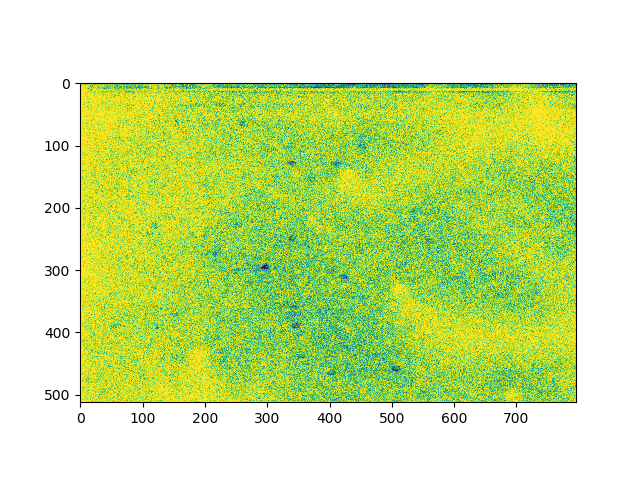

In [14]:
from pylab import plt
%matplotlib notebook
plt.figure()
plt.plot(colprofile)

In [15]:
plt.imshow(tmpsbx[6,0,0,:,:])

In [175]:
print('\t Computing line shifts and columns to discard from the first run.')
tmpsbx = sbx_memmap(files[0][0])
colprofile = np.mean(tmpsbx[0][0][0],axis = 0)
colidx = np.argmax(np.diff(colprofile)) + 1
lineshift = int(-1*estimate2PLineShift(tmpsbx[:1000,0,0,100:-100,100:-100]))
print('\t\t lineshift on the first run is {0}'.format(lineshift))
print('\t\t column index on the first run is {0}'.format(colidx))
del tmpsbx
print('\t Checking if files are corrupted.')
for x in files:
    tmpsbx = sbx_memmap(x[0])
    if tmpsbx[-1].std() == 0:
        raise(ValueError('File {0} is likely corrupted.'.format(x[0])))
    del tmpsbx
blocksize = opts.blocksize
prepared = [prepareSBXdaskLoad(x[0],blocksize=blocksize,
                               trimleft = int(colidx),
                               trimright = int(0), 
                               shiftLines = int(lineshift)) for x in files]
infos = [s[2] for s in prepared]
dims = [s[1] for s in prepared]
stacks = [s[0] for s in prepared]
# Connect to the dask client

client = Client(scheduler_file=opts.client)     

if not opts.no_registration:
    tstart = time.time()
    refs = [r.result() for r in computeReferenceImages(stacks,
                                                       client=client,
                                                       reg = True)]
    #imsave('/home/mouselab/test_ref.tif',refs[0][0])

    print('Refs toke: {0:.3f} s'.format(time.time() - tstart))
    
    # Compute shifts between runs
    errmat = np.zeros(np.array([0,1,1])*len(refs) + np.array([1,0,0])*len(refs[0]))
    shiftsmat = np.zeros(np.array([0,1,1,0])*len(refs) + np.array([1,0,0,0])*len(refs[0]) + np.array([0,0,0,2]))
    for i,ref1 in enumerate(refs):
        for j,ref2 in enumerate(refs):
            for p in range(len(ref1)):
                shiftsmat[p,i,j,:],errmat[p,i,j],_ = register_translation(np.squeeze(ref1[p,0,100:-100,100:-100]),
                                                                      np.squeeze(ref2[p,0,100:-100,100:-100]))


    # Compute the alignment subpixel correction values
    aligncorrection = []
    for i,ref in enumerate(refs):
        aligncorrection.append([])
        for r in ref:
            shift,_,_ = register_translation(r[0,:,::2],r[0,:,1::2],upsample_factor=10)
            aligncorrection[-1].append(shift[1])
    from scipy.stats import mode
    aligncorrection = [mode(a)[0] for a in aligncorrection]
    # Plot stuff
    plots = False
    if plots:
        for ref in refs:
            fig = plt.figure()
            nplanes = ref.shape[0]
            for i in range(nplanes):
                fig.add_subplot(np.ceil(nplanes/2.),2,i+1)
                plt.imshow(np.squeeze(ref[i]))
        fig = plt.figure()
        for e,err in enumerate(errmat):
            nplots = len(errmat)
            ax = plt.subplot(np.ceil(nplots/2),2,e+1)
            plt.title('Plane {0}'.format(e),fontsize=10)
            im = plt.imshow(err,interpolation=None,origin='bottom',clim = [0,0.5],cmap = 'hot')
            ax.set_xticks(np.arange(len(err),dtype=int))
            ax.set_yticks(np.arange(len(err),dtype=int))
            if e < nplots-2:
                ax.set_xticks([])
            else:
                plt.xlabel('# run')
            if e == nplots-1:
                cb = plt.colorbar(im,shrink = 0.5, pad = 0.1)
            plt.suptitle('Error between sessions',fontsize=14)

    if not opts.independent_runs:
        selectedRun = int(len(runs)/2)
        print('Registering to run {0}'.format(selectedRun))
        refs = [refs[selectedRun] for ref in refs]

    # Register all sessions
    regstacks = []
    savestacks = []
    for i,(ref,stack) in enumerate(zip(refs,stacks)):
        regstacks.append(stack.map_blocks(regFrames,ref,
                                          dtype=np.uint16))
        fname = os.path.basename(os.path.splitext(files[i][0])[0])
        if multiplane_tiffs:
            fname = os.path.abspath(pjoin(destfolder,
                                          expname,
                                          runs[i],
                                          fname+'_volumeplanes_{0:03d}_{1:04d}.tif'))
        else:
            fname = os.path.abspath(pjoin(destfolder,
                                          expname,
                                          runs[i],
                                          'plane{0:03d}_ch{1:02d}',
                                          fname+'_{2:04d}.tif'))

            # recfname = os.path.abspath(pjoin(destfolder.replace('/reg','/rec'),expname,runs[i],'plane{0:03d}_ch{1:02d}',fname+'_{2:04d}.tif'))
            # savestacks.append(stack.map_blocks(stackToTiff,recfname,drop_axis=[1,2,3,4]))
        savestacks.append(regstacks[-1].map_blocks(stackToTiff,
                                                   fname,
                                                   multiplane_tiffs = multiplane_tiffs,
                                                   drop_axis=[1,2,3,4]))

    tstart = time.time()
    res = [r.result() for r in client.compute(savestacks)]
    print('Reg frames toke: {0:.3f} min'.format((time.time() - tstart)/60.))
    print('Completed registration in: {0:.3f} min'.format((time.time() - abstime)/60.))


	 Computing line shifts and columns to discard from the first run.
		 lineshift on the first run is -1
		 column index on the first run is 98
	 Checking if files are corrupted.
		 Number of frames: 20772
(1, 796, 700, 4)
Refs toke: 106.441 s
Registering to run 0
Reg frames toke: 1.604 min
Completed registration in: 38.697 min


In [131]:
stacks

[dask.array<concatenate, shape=(5193, 4, 1, 700, 0), dtype=uint16, chunksize=(128, 4, 1, 700, 0)>]

In [8]:
if not opts.no_registration:
    tstart = time.time()
    prepared = [prepareSBXdaskLoad(x[0],blocksize=blocksize) for x in files]
    infos = [s[2] for s in prepared]
    dims = [s[1] for s in prepared]
    stacks = [s[0] for s in prepared]
    refs = [r.result() for r in computeReferenceImages(stacks,client=client,reg = True)]
    print('Refs toke: {0:.3f} s'.format(time.time() - tstart))
    # Compute shifts between runs
    errmat = np.zeros(np.array([0,1,1])*len(refs) + np.array([1,0,0])*len(refs[0]))
    shiftsmat = np.zeros(np.array([0,1,1,0])*len(refs) + np.array([1,0,0,0])*len(refs[0]) + np.array([0,0,0,2]))
    for i,ref1 in enumerate(refs):
        for j,ref2 in enumerate(refs):
            for p in range(len(ref1)):
                shiftsmat[p,i,j,:],errmat[p,i,j],_ = register_translation(np.squeeze(ref1[p,0,100:-100,100:-100]),
                                                                      np.squeeze(ref2[p,0,100:-100,100:-100]))
    # Compute the alignment subpixel correction values
    aligncorrection = []
    for i,ref in enumerate(refs):
        aligncorrection.append([])
        for r in ref:
            shift,_,_ = register_translation(r[0,101:-99:2,100:-100],
                                             r[0,100:-100:2,100:-100],upsample_factor=10)
            aligncorrection[-1].append(shift[1])
    #from scipy.stats import mode
    #aligncorrection = [mode(a)[0] for a in aligncorrection]
    aligncorrection = [np.mean(a) for a in aligncorrection]
    # Plot stuff    
    plots = False
    if plots:
        for ref in refs:
            fig = plt.figure()
            nplanes = ref.shape[0]
            for i in range(nplanes):
                fig.add_subplot(np.ceil(nplanes/2.),2,i+1)
                plt.imshow(np.squeeze(ref[i]))
        fig = plt.figure()
        for e,err in enumerate(errmat):
            nplots = len(errmat)
            ax = plt.subplot(np.ceil(nplots/2),2,e+1)
            plt.title('Plane {0}'.format(e),fontsize=10)
            im = plt.imshow(err,interpolation=None,origin='bottom',clim = [0,0.5],cmap = 'hot')
            ax.set_xticks(np.arange(len(err),dtype=int))
            ax.set_yticks(np.arange(len(err),dtype=int))
            if e < nplots-2:
                ax.set_xticks([])
            else:
                plt.xlabel('# run')
            if e == nplots-1:
                cb = plt.colorbar(im,shrink = 0.5, pad = 0.1)
            plt.suptitle('Error between sessions',fontsize=14)

    if not opts.independent_runs:
        selectedRun = int(len(runs)/2)
        print('Registering to run {0}'.format(selectedRun))
        refs = [refs[selectedRun] for ref in refs]
# Registration of all frames
if not opts.no_registration:
    # Register all sessions
    regstacks = []
    savestacks = []
    for i,(ref,stack) in enumerate(zip(refs,stacks)):
        regstacks.append(stack.map_blocks(regFrames,ref,#alignShift = aligncorrection[i],
                                          dtype=np.uint16))
        fname = os.path.basename(os.path.splitext(files[i][0])[0])

        if multiplane_tiffs:
            fname = os.path.abspath(pjoin(destfolder,
                                           expname,
                                           runs[i],
                                           fname+'_volumeplanes_{0:03d}_{1:04d}.tif'))
        else:
            fname = os.path.abspath(pjoin(destfolder,
                                          expname,
                                          runs[i],
                                          'plane{0:03d}_ch{1:02d}',
                                          fname+'_{2:04d}.tif'))

            # recfname = os.path.abspath(pjoin(destfolder.replace('/reg','/rec'),expname,runs[i],'plane{0:03d}_ch{1:02d}',fname+'_{2:04d}.tif'))
            # savestacks.append(stack.map_blocks(stackToTiff,recfname,drop_axis=[1,2,3,4]))
        savestacks.append(regstacks[-1].map_blocks(stackToTiff,
                                                   fname,
                                                   multiplane_tiffs = multiplane_tiffs,
                                                   dtype = np.uint16,
                                                   drop_axis=[1,2,3,4]))

    tstart = time.time()
    res = [r.result() for r in client.compute(savestacks)]
    print('Reg frames toke: {0:.3f} min'.format((time.time() - tstart)/60.))

    print('Completed registration in: {0:.3f} min'.format((time.time() - abstime)/60.))

Refs toke: 87.416 s
Registering to run 2


TypeError: object of type 'int' has no len()

In [43]:
aligncorrection = []
for i,ref in enumerate(refs):
    aligncorrection.append([])
    for r in ref:
        shift,_,_ = register_translation(r[0,101:-99:2,100:-100],
                                         r[0,100:-100:2,100:-100],upsample_factor=10)
        aligncorrection[-1].append(shift[1])
aligncorrection

[[0.59999999999999998, 1.3, 1.6000000000000001, 1.6000000000000001]]

<IPython.core.display.Javascript object>


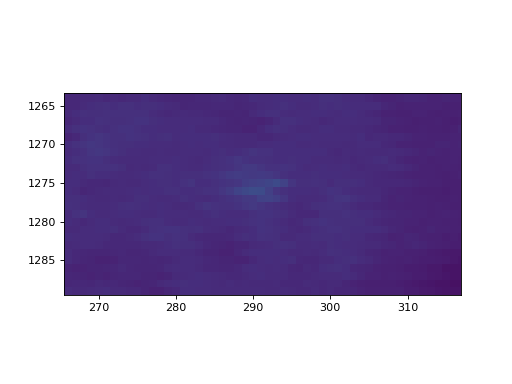

In [6]:
%matplotlib notebook
import pylab as plt
plt.imshow(np.concatenate([r[0] for r in refs[0]],axis=0))

<IPython.core.display.Javascript object>


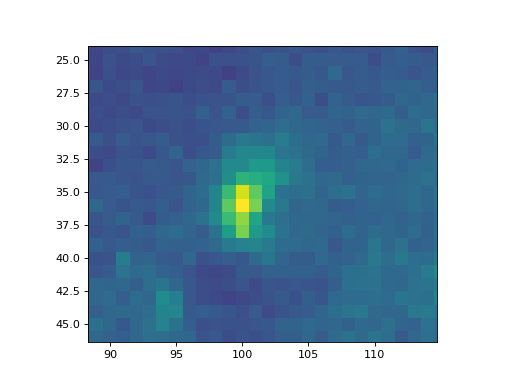

<IPython.core.display.Javascript object>


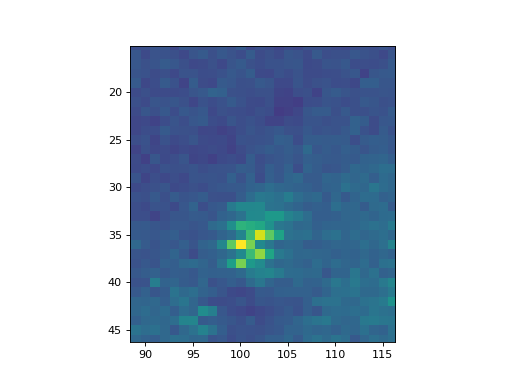

In [113]:
%matplotlib notebook
import cv2
alignShift = -1.6
res = np.array(stacks[0][:1000])
for iFrame in range(len(res)):
    for iPlane in range(len(res[0])):
        for iChannel in [0]:
            tmp = res[iFrame,iPlane,iChannel,1::2,:]
            th,tw = tmp.shape 
            m = np.float32([[1,0,alignShift],
                            [0,1,0]])
            res[iFrame,iPlane,iChannel,1::2,:] = warpAffine(tmp,m,(tw,th),flags=cv2.INTER_NEAREST)
plt.figure()

plt.imshow(res[:,2,0,100:-300,200:-100].std(axis = 0))
plt.figure()
plt.imshow(stacks[0][:1000,2,0,100:-300,200:-100].std(axis = 0))

#plt.imshow(refs[0][0,0,100:-100,100:-100])

<IPython.core.display.Javascript object>


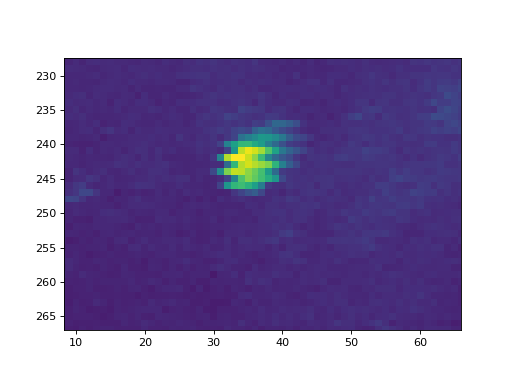

In [105]:
%matplotlib notebook
plt.imshow(stacks[0][:1000,2,0,100:,100:].std(axis = 0))


<IPython.core.display.Javascript object>


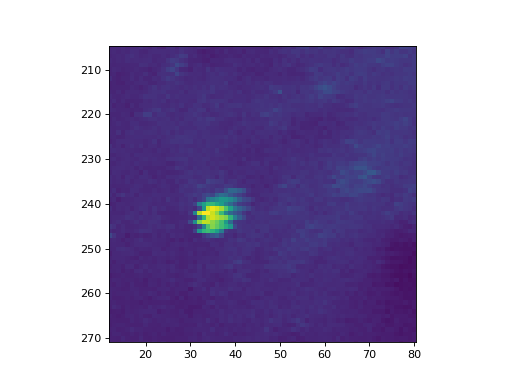

In [109]:
%matplotlib notebook
plt.imshow(stacks[0][:1000,2,0,100:,100:].std(axis = 0))


In [12]:
# projections
if not opts.no_projections:
    print('Computing projections from reg data.')
    client.restart()
    regfolder  = pjoin(destfolder,expname)
    sessionfolders = np.sort(os.listdir(regfolder))
    runs = []
    files = []
    for r in sessionfolders:
        if os.path.isdir(pjoin(regfolder,r)):
            planefolders = np.sort(os.listdir(pjoin(regfolder,r)))
            for p in planefolders:
                if os.path.isdir(pjoin(regfolder,r,p)):
                    f = np.sort(glob(pjoin(regfolder,r,p,'*.tif')))
                    if not r in runs and not 'stack' in r:
                        runs.append(r)
                        files.append([])
                        print('\t' + r)
                    print('\t\t' + p)
                    files[-1].append(f)
    stacks = []
    for ses in files:
        stacks.append([])
        for planes in ses:
            stacks[-1].append(loadTiffsToDask(planes))
    tstart = time.time()
    projections,downsampled = daskComputeProjections(
        stacks,
        client,
        ndownsample = nFramesDownsample)
    # Wait for it..
    projections = [[np.dstack([t.compute() for t in p]) 
                    for p in pp] for pp in projections]
    print('Downsampling on cluster and computing projections toke: {0} min'.format((time.time() - tstart)/60))
    # Save projections to reg_ds
    dsdestfolder = os.path.abspath(pjoin(os.path.split(os.path.abspath(destfolder))[0],'reg_ds'))
    projfiles = []
    for filesrun,projection in zip(files,projections):
        projfiles.append([])
        for plane,proj in zip(filesrun,projection):
            #dirname = os.path.dirname(plane[0])
            dirname = os.path.abspath(os.path.dirname(plane[0].replace(os.path.abspath(destfolder),dsdestfolder)))
            fname = dirname+'.tifproj'
            projfiles[-1].append(fname)
            try:
                os.makedirs(os.path.dirname(fname))
            except:
                pass
            imsave(fname,proj.astype(np.float32).transpose([2,0,1]))

    # Save downsampled stacks...
    dsfiles = []
    tasks = []
    for filesrun,dsstacks in zip(files,downsampled):
        dsfiles.append([])
        for plane,dsstack in zip(filesrun,dsstacks):
            dirname = os.path.abspath(os.path.dirname(plane[0].replace(os.path.abspath(destfolder),dsdestfolder)))
            fname = os.path.basename(dirname)
            tmp = fname.split('_')
            tmp = '_'.join(tmp[:-1]+['{0:04d}.tif'])
            fname = pjoin(dirname,tmp)
            dsfiles[-1].append(fname)
            dsstack_rechunked = dsstack.rechunk([400,dsstack.shape[1],dsstack.shape[2]])
            tasks.append(dsstack_rechunked.map_blocks(dsregToTiff,dsfiles[-1][-1],drop_axis=[1,2]))

    [t.result() for t in client.compute(tasks)]
    print('Completed registration and projections in: {0:.3f} min'.format((time.time() - abstime)/60.))


Computing projections from reg data.


OSError: [Errno 2] No such file or directory: 'dest/171121_XH303_2P_XH'

In [106]:
def regFrames(frames,ref,offset = [0,0], alignShift = 0,discardBorder = 100,iChannelReg = 0):
    nFrames,nPlanes,nChannels,height,width = frames.shape
    #shifts = np.zeros([nFrames,nPlanes,2],dtype=np.float32)
    res = np.zeros_like(frames)

    setNumThreads(1)
    for iPlane in range(nPlanes):
        reference = ref[iPlane][iChannelReg][discardBorder:-1-discardBorder:2,
                                             discardBorder:-1-discardBorder]
        for iFrame in range(nFrames):
            frame = frames[iFrame,iPlane,iChannelReg,
                           discardBorder:-1-discardBorder:2,
                           discardBorder:-1-discardBorder]
            shift,_,_ = register_translation(reference,frame,upsample_factor=6)
            #shifts[iFrame,iPlane,:] = shift[:].astype('float32')
            M = np.float32([[1,0,shift[1] + offset[1]],
                            [0,1,shift[0]+ offset[0]]])
            M1 = np.float32([[1,0,shift[1] + offset[1] + alignShift],
                            [0,1,shift[0]+ offset[0]]])
 
            for iChannel in range(nChannels):
                if alignShift != 0:
                    h,w = res[0,0,0,1::2,:].shape 
                    res[iFrame,iPlane,iChannel,1::2,:] = warpAffine(frames[iFrame,
                                                                        iPlane,
                                                                        iChannel,
                                                                        1::2,:],
                                                                 M1,(w,h))
                    h,w = res[0,0,0,0::2,:].shape 
                    res[iFrame,iPlane,iChannel,0::2,:] = warpAffine(frames[iFrame,
                                                                        iPlane,
                                                                        iChannel,
                                                                        0::2,:],
                                                                    M,(w,h))                

                else:
                    res[iFrame,iPlane,iChannel,:,:] = warpAffine(frames[iFrame,
                                                                        iPlane,
                                                                        iChannel,
                                                                        :,:],
                                                                 M,(width,height))
    return res